In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from model_module import model_preparation, best_model
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [223]:
df = pd.read_csv("./data/angelone_eq_15min_2018_2025.csv").set_index("datetime").drop(columns=["timestamp"])
# Convert df index to datetime (add this RIGHT AFTER loading/creating df)
df.index = pd.to_datetime(df.index)
df.head()

,open,high,low,close,volume
datetime,,,,,
2020-10-05 09:45:00+05:30,275.0,275.00,275.00,275.0,306762
2020-10-05 10:00:00+05:30,275.0,275.00,275.00,275.0,0
2020-10-05 10:15:00+05:30,272.6,292.35,257.00,278.6,2886820
2020-10-05 10:30:00+05:30,278.6,292.40,275.00,286.7,949825
2020-10-05 10:45:00+05:30,286.7,294.80,285.55,294.0,831097


#### Creating Features

    Directional momentum

In [224]:
# Trend direction
df['green_candle'] = (df['close'] > df['open']).astype(int)
df['higher_high'] = (df['high'] > df['high'].shift(1)).astype(int)
df['lower_low'] = (df['low'] < df['low'].shift(1)).astype(int)
df['close_above_sma13'] = (df['close'] > df['close'].rolling(13).mean()).astype(int)
df['close_above_sma26'] = (df['close'] > df['close'].rolling(26).mean()).astype(int)

# # Momentum direction
# df['return_1_sign'] = np.sign(df['log_return'].shift(1))
# df['return_4_positive'] = (df['return_4'] > 0).astype(int)
# df['return_13_positive'] = (df['return_13'] > 0).astype(int)

In [225]:
# Time features (datetime is index)
df['hour'] = pd.to_datetime(df.index).hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_of_week'] = pd.to_datetime(df.index).dayofweek

In [226]:
df['hl_ratio'] = (df['high'] - df['low']) / df['close']
df['upper_shadow'] = (df['high'] - df[['open', 'close']].max(axis=1)) / df['close']
df['lower_shadow'] = (df[['open', 'close']].min(axis=1) - df['low']) / df['close']

    momentum Features

In [227]:
df['return_4'] = np.log(df['close'] / df['close'].shift(4))   # 1 hour
df['return_13'] = np.log(df['close'] / df['close'].shift(13)) # ~3 hours
df['return_26'] = np.log(df['close'] / df['close'].shift(26)) # 1 day

    Volume

In [228]:
df = df.copy()
lookback = 20  # 20 bars = 5 hours of 15min data

df["volume_ma"] = df["volume"].rolling(window=lookback).mean()
df["volume_ratio"] = df["volume"] / df["volume_ma"]

# Clean up
df = df.dropna(how="any")

    RSI

In [229]:
# RSI calculation
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Add RSI with standard 14-period
df["rsi_14"] = calculate_rsi(df["close"], period=14)

# Clean up
df = df.dropna(how="any")

# Check the feature
print("RSI Statistics:")
print(df["rsi_14"].describe())
print(f"\nOverbought (>70): {(df['rsi_14'] > 70).sum()} bars")
print(f"Oversold (<30): {(df['rsi_14'] < 30).sum()} bars")


RSI Statistics:
count    32008.000000
mean        49.333163
std         19.061507
min          0.000000
25%         35.177163
50%         49.368087
75%         63.157895
max        100.000000
Name: rsi_14, dtype: float64

Overbought (>70): 4874 bars
Oversold (<30): 5469 bars


    MACD

In [230]:
# MACD calculation
def calculate_macd(data, fast=12, slow=26, signal=9):
    ema_fast = data.ewm(span=fast, adjust=False).mean()
    ema_slow = data.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    return macd_line, signal_line, macd_histogram

df["macd"], df["macd_signal"], df["macd_hist"] = calculate_macd(df["close"])

# Normalize MACD features by price (make them relative)
df["macd_norm"] = df["macd"] / df["close"]
df["macd_hist_norm"] = df["macd_hist"] / df["close"]

# Clean up
df = df.dropna(how="any")

print("MACD Statistics:")
print(df[["macd_norm", "macd_hist_norm"]].describe())

MACD Statistics:
          macd_norm  macd_hist_norm
count  32008.000000    32008.000000
mean       0.000345        0.000005
std        0.007443        0.002041
min       -0.049496       -0.016980
25%       -0.003475       -0.000954
50%        0.000006       -0.000060
75%        0.003886        0.000902
max        0.045701        0.016795


    Moving Averages

In [231]:
# Moving averages (just for calculation, not direct features)
df["5ma"] = df["close"].rolling(5).mean()
df["10ma"] = df["close"].rolling(10).mean()
df["50ma"] = df["close"].rolling(50).mean()
df["200ma"] = df["close"].rolling(200).mean()  # Fixed: was 100

# RELATIVE features (normalized by price)
df["5_10_ma_diff_pct"] = (df["5ma"] - df["10ma"]) / df["close"]
df["close_5ma_diff_pct"] = (df["close"] - df["5ma"]) / df["close"]
df["close_10ma_diff_pct"] = (df["close"] - df["10ma"]) / df["close"]
df["golden_cross_pct"] = (df["50ma"] - df["200ma"]) / df["close"]

# Additional useful MA features
df["close_50ma_diff_pct"] = (df["close"] - df["50ma"]) / df["close"]
df["close_200ma_diff_pct"] = (df["close"] - df["200ma"]) / df["close"]

# Slope/momentum of MAs (rate of change)
df["5ma_roc"] = df["5ma"].pct_change(periods=5)
df["50ma_roc"] = df["50ma"].pct_change(periods=10)


In [232]:
# High-Low range features
df["hl_range"] = (df["high"] - df["low"]) / df["close"]  # Normalized
df["hl_range_ma"] = df["hl_range"].rolling(20).mean()
df["hl_range_ratio"] = df["hl_range"] / df["hl_range_ma"]  # Current vs average

# Close position within bar
df["close_position"] = (df["close"] - df["low"]) / (df["high"] - df["low"])  # 0 to 1

df = df.dropna()

    Candlestick/Microstructure Features

In [233]:
# === CANDLESTICK BODY & WICKS ===
df["body_size"] = abs(df["close"] - df["open"]) / df["close"]
df["upper_wick"] = (df["high"] - df[["open", "close"]].max(axis=1)) / df["close"]
df["lower_wick"] = (df[["open", "close"]].min(axis=1) - df["low"]) / df["close"]

# Body direction
df["body_direction"] = np.sign(df["close"] - df["open"])

# === OPEN-CLOSE RELATIONSHIPS ===
df["open_close_diff"] = (df["close"] - df["open"]) / df["close"]
df["high_close_diff"] = (df["high"] - df["close"]) / df["close"]
df["low_close_diff"] = (df["close"] - df["low"]) / df["close"]

# === VOLUME-WEIGHTED PRICE (VWAP) ===
df["vwap_5"] = (df["close"] * df["volume"]).rolling(5).sum() / df["volume"].rolling(5).sum()
df["vwap_10"] = (df["close"] * df["volume"]).rolling(10).sum() / df["volume"].rolling(10).sum()
df["vwap_5_diff"] = (df["close"] - df["vwap_5"]) / df["close"]
df["vwap_10_diff"] = (df["close"] - df["vwap_10"]) / df["close"]

# === MOMENTUM OF MICROSTRUCTURE ===
df["close_position_change"] = df["close_position"].diff()
df["body_size_ratio"] = df["body_size"] / df["body_size"].rolling(10).mean()

# === BUYING/SELLING PRESSURE PROXIES ===
# Approximation: If close near high = buying pressure
df["buying_pressure"] = (df["close"] - df["low"]) / (df["high"] - df["low"] + 1e-10)
df["selling_pressure"] = (df["high"] - df["close"]) / (df["high"] - df["low"] + 1e-10)

# Clean up
df = df.dropna()

print(f"Added microstructure features. New shape: {df.shape}")

Added microstructure features. New shape: (31661, 59)


#### Creating Target

In [234]:
df["close_log_return"] = np.log(df["close"] / df["close"].shift(1))
df = df.dropna(how="any")

    Shift to avoid lookahead bias

In [235]:
df = df.copy()
df["shifted_log_return"] = df["close_log_return"].shift(-1)

In [236]:
df["close_log_return_lag1"] = df["shifted_log_return"].shift(1)
df["close_log_return_lag2"] = df["shifted_log_return"].shift(2)
df["close_log_return_lag3"] = df["shifted_log_return"].shift(3)
df = df.dropna(how="any")

#### Visualization discarded for later

In [237]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import stats

# # Assuming your data is loaded
# # df has columns: ['open', 'high', 'low', 'close', 'volume']

# # Calculate log returns (1-bar forward)
# df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# # Remove NaN
# df = df.dropna()

# # ============================================
# # 1. BASIC STATISTICS
# # ============================================
# print("="*60)
# print("LOG RETURNS DISTRIBUTION ANALYSIS")
# print("="*60)
# print(f"Total samples: {len(df)}")
# print(f"Mean: {df['log_return'].mean():.6f}")
# print(f"Std Dev: {df['log_return'].std():.6f}")
# print(f"Skewness: {df['log_return'].skew():.4f}")
# print(f"Kurtosis: {df['log_return'].kurtosis():.4f}")
# print(f"Min: {df['log_return'].min():.4f}")
# print(f"Max: {df['log_return'].max():.4f}")
# print()

# # ============================================
# # 2. PERCENTILE ANALYSIS (CRITICAL)
# # ============================================
# percentiles = [1, 5, 10, 20, 25, 40, 50, 60, 75, 80, 90, 95, 99]
# print("PERCENTILE BREAKDOWN:")
# print("-" * 60)
# for p in percentiles:
#     val = np.percentile(df['log_return'], p)
#     print(f"{p:3d}th percentile: {val:8.4f} ({val*100:6.2f}%)")
# print()

# # ============================================
# # 3. PROPOSED CLASS BOUNDARIES
# # ============================================
# # Based on symmetric percentiles
# p10 = np.percentile(df['log_return'], 10)  # Class 4: Big Down
# p30 = np.percentile(df['log_return'], 30)  # Class 2: Small Down
# p70 = np.percentile(df['log_return'], 70)  # Class 1: Small Up
# p90 = np.percentile(df['log_return'], 90)  # Class 3: Big Up

# print("PROPOSED CLASS BOUNDARIES (Percentile-based):")
# print("-" * 60)
# print(f"Class 4 (Big Down):    return < {p10:.4f} ({p10*100:.2f}%)")
# print(f"Class 2 (Small Down):  {p10:.4f} to {p30:.4f}")
# print(f"Class 0 (Neutral):     {p30:.4f} to {p70:.4f}")
# print(f"Class 1 (Small Up):    {p70:.4f} to {p90:.4f}")
# print(f"Class 3 (Big Up):      return > {p90:.4f} ({p90*100:.2f}%)")
# print()

# # Alternative: Fixed percentage boundaries
# print("ALTERNATIVE: FIXED PERCENTAGE BOUNDARIES:")
# print("-" * 60)
# print(f"Class 4 (Big Down):    return < -0.50%")
# print(f"Class 2 (Small Down):  -0.50% to -0.15%")
# print(f"Class 0 (Neutral):     -0.15% to +0.15%")
# print(f"Class 1 (Small Up):    +0.15% to +0.50%")
# print(f"Class 3 (Big Up):      return > +0.50%")
# print()

# # Count samples in fixed boundaries
# class_4_count = len(df[df['log_return'] < -0.005])
# class_2_count = len(df[(df['log_return'] >= -0.005) & (df['log_return'] < -0.0015)])
# class_0_count = len(df[(df['log_return'] >= -0.0015) & (df['log_return'] < 0.0015)])
# class_1_count = len(df[(df['log_return'] >= 0.0015) & (df['log_return'] < 0.005)])
# class_3_count = len(df[df['log_return'] >= 0.005])

# print("Sample counts with fixed boundaries:")
# print(f"Class 0 (Neutral): {class_0_count} ({class_0_count/len(df)*100:.1f}%)")
# print(f"Class 1 (Small Up): {class_1_count} ({class_1_count/len(df)*100:.1f}%)")
# print(f"Class 2 (Small Down): {class_2_count} ({class_2_count/len(df)*100:.1f}%)")
# print(f"Class 3 (Big Up): {class_3_count} ({class_3_count/len(df)*100:.1f}%)")
# print(f"Class 4 (Big Down): {class_4_count} ({class_4_count/len(df)*100:.1f}%)")
# print()

# # ============================================
# # 4. VISUALIZATION
# # ============================================
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# # Histogram with KDE
# axes[0, 0].hist(df['log_return'], bins=100, alpha=0.7, color='steelblue', edgecolor='black')
# axes[0, 0].axvline(df['log_return'].mean(), color='red', linestyle='--', label=f'Mean: {df["log_return"].mean():.4f}')
# axes[0, 0].axvline(0, color='black', linestyle='-', alpha=0.3, label='Zero')
# axes[0, 0].set_xlabel('Log Return')
# axes[0, 0].set_ylabel('Frequency')
# axes[0, 0].set_title('Distribution of Log Returns')
# axes[0, 0].legend()
# axes[0, 0].grid(alpha=0.3)

# # Q-Q Plot (Test for normality)
# stats.probplot(df['log_return'], dist="norm", plot=axes[0, 1])
# axes[0, 1].set_title('Q-Q Plot (Normality Test)')
# axes[0, 1].grid(alpha=0.3)

# # Boxplot
# axes[1, 0].boxplot(df['log_return'], vert=True)
# axes[1, 0].set_ylabel('Log Return')
# axes[1, 0].set_title('Boxplot (Outlier Detection)')
# axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
# axes[1, 0].grid(alpha=0.3)

# # Class boundaries visualization
# axes[1, 1].hist(df['log_return'], bins=100, alpha=0.5, color='gray', edgecolor='black')
# axes[1, 1].axvline(p10, color='red', linestyle='--', linewidth=2, label=f'10th: {p10:.4f}')
# axes[1, 1].axvline(p30, color='orange', linestyle='--', linewidth=2, label=f'30th: {p30:.4f}')
# axes[1, 1].axvline(p70, color='green', linestyle='--', linewidth=2, label=f'70th: {p70:.4f}')
# axes[1, 1].axvline(p90, color='blue', linestyle='--', linewidth=2, label=f'90th: {p90:.4f}')
# axes[1, 1].set_xlabel('Log Return')
# axes[1, 1].set_ylabel('Frequency')
# axes[1, 1].set_title('Proposed Class Boundaries (Percentile-based)')
# axes[1, 1].legend()
# axes[1, 1].grid(alpha=0.3)

# plt.tight_layout()
# plt.savefig('log_returns_distribution_analysis.png', dpi=300, bbox_inches='tight')
# plt.show()

# # ============================================
# # 5. NORMALITY TEST
# # ============================================
# # Jarque-Bera test
# jb_stat, jb_pvalue = stats.jarque_bera(df['log_return'])
# print("NORMALITY TESTS:")
# print("-" * 60)
# print(f"Jarque-Bera statistic: {jb_stat:.2f}")
# print(f"Jarque-Bera p-value: {jb_pvalue:.6f}")
# if jb_pvalue < 0.05:
#     print("→ Returns are NOT normally distributed (reject null)")
# else:
#     print("→ Returns appear normally distributed")
# print()

# # ============================================
# # 6. AUTOCORRELATION CHECK
# # ============================================
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# fig, axes = plt.subplots(1, 2, figsize=(15, 4))
# plot_acf(df['log_return'].dropna(), lags=50, ax=axes[0])
# axes[0].set_title('Autocorrelation Function (ACF)')
# plot_pacf(df['log_return'].dropna(), lags=50, ax=axes[1])
# axes[1].set_title('Partial Autocorrelation Function (PACF)')
# plt.tight_layout()
# plt.savefig('autocorrelation_analysis.png', dpi=300, bbox_inches='tight')
# plt.show()

# print("ACF/PACF analysis saved. Check for:")
# print("- Significant lags → momentum/mean reversion patterns")
# print("- All lags near zero → random walk (no predictability)")
# print()

# # ============================================
# # 7. TIME-BASED ANALYSIS
# # ============================================
# # Assuming you have datetime index
# if 'datetime' in df.columns or isinstance(df.index, pd.DatetimeIndex):
#     if 'datetime' not in df.columns:
#         df['datetime'] = df.index
    
#     df['hour'] = pd.to_datetime(df['datetime']).dt.hour
#     df['year'] = pd.to_datetime(df['datetime']).dt.year
    
#     print("VOLATILITY BY HOUR (Intraday Pattern):")
#     print("-" * 60)
#     hourly_stats = df.groupby('hour')['log_return'].agg(['mean', 'std', 'count'])
#     print(hourly_stats)
#     print()
    
#     print("ANNUAL STATISTICS (Regime Changes):")
#     print("-" * 60)
#     yearly_stats = df.groupby('year')['log_return'].agg(['mean', 'std', 'count'])
#     print(yearly_stats)
#     print()

# print("="*60)
# print("ANALYSIS COMPLETE")
# print("="*60)

#### Model Preparation

    Creating Target and Deciding Features

     Top 10 features by importance

In [238]:
X = df[[
   
    "hl_ratio",              # 26.9% - #1
    "body_size",             # 13.0% - #2
    "hour_cos",              # 10.5% - #3
    "volume_ratio",          # 9.4%  - #4
    "hour_sin",              # 8.1%  - #5
    "high_close_diff",       # 7.7%  - #6
    "close_5ma_diff_pct",    # 5.7%  - #7
    "close_log_return_lag1", # 4.1%  - #8
    "upper_shadow",          # 3.2%  - #9
    "lower_shadow"           # 3.0%  - #10
]]
# y = (df["shifted_log_return"] > 0).astype(int)

In [239]:
# Calculate expanding percentiles on PAST data only
df['p10'] = df['shifted_log_return'].expanding(min_periods=1000).quantile(0.10).shift(1)
df['p30'] = df['shifted_log_return'].expanding(min_periods=1000).quantile(0.30).shift(1)
df['p70'] = df['shifted_log_return'].expanding(min_periods=1000).quantile(0.70).shift(1)
df['p90'] = df['shifted_log_return'].expanding(min_periods=1000).quantile(0.90).shift(1)

def label_class_expanding(row):
    ret = row['shifted_log_return']
    p10, p30, p70, p90 = row['p10'], row['p30'], row['p70'], row['p90']
    
    if ret < p10: return 4      # Big Down
    elif ret < p30: return 2    # Small Down
    elif ret < p70: return 0    # Neutral
    elif ret < p90: return 1    # Small Up
    else: return 3              # Big Up

df['target'] = df.apply(label_class_expanding, axis=1)

# Drop the percentile columns (don't use as features)
df = df.drop(columns=['p10', 'p30', 'p70', 'p90'])

# Drop NaN
df = df.dropna()

print(df['target'].value_counts().sort_index())

target
0    12316
1     6543
2     6365
3     3732
4     2700
Name: count, dtype: int64


In [240]:
y = df["target"]

### Model

#### Best model after hyperparameter tuning

In [241]:
# Assuming your data has a datetime index
# Split by date: e.g., train on data before 2023, test on 2023+
train_end_date = '2025-09-30'  # Adjust this to your desired split date

# Split based on date
X_train = X[X.index <= train_end_date]
X_test = X[X.index > train_end_date]
y_train = y[y.index <= train_end_date]
y_test = y[y.index > train_end_date]

print(f"Train period: {X_train.index.min()} to {X_train.index.max()}")
print(f"Test period: {X_test.index.min()} to {X_test.index.max()}")
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

# Rest of your model code
model = RandomForestClassifier(
    n_estimators=500,
    max_depth=3,
    min_samples_split=100,
    min_samples_leaf=50,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Get predictions once to reuse
y_pred = model.predict(X_test)

print(f"\nTrain score: {accuracy_score(y_train, model.predict(X_train)):.4f}")
print(f"Test score: {accuracy_score(y_test, y_pred):.4f}")
print(f"\nTest Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

Train period: 2020-10-19 10:00:00+05:30 to 2025-09-29 15:30:00+05:30
Test period: 2025-09-30 09:30:00+05:30 to 2025-12-12 15:15:00+05:30
Train samples: 30403, Test samples: 1253

Train score: 0.3607
Test score: 0.3559

Test Confusion Matrix:
[[353  62  26  44  54]
 [172  36  18  30  49]
 [156  25  16  30  42]
 [ 22   9   8  23  23]
 [ 15   5   5  12  18]]

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.65      0.56       539
           1       0.26      0.12      0.16       305
           2       0.22      0.06      0.09       269
           3       0.17      0.27      0.21        85
           4       0.10      0.33      0.15        55

    accuracy                           0.36      1253
   macro avg       0.25      0.29      0.23      1253
weighted avg       0.34      0.36      0.32      1253



In [242]:
len(df)

31656

In [243]:
len(X)

31656

In [244]:
y_pred = model.predict(X_test)

In [245]:
y_pred_probab = model.predict_proba(X_test)

In [246]:
y_pred_probab

array([[0.08948981, 0.1619569 , 0.15378823, 0.27455984, 0.32020522],
       [0.21673644, 0.20403146, 0.21046723, 0.19488184, 0.17388304],
       [0.25367069, 0.21752175, 0.235106  , 0.15243989, 0.14126168],
       ...,
       [0.21092194, 0.23108899, 0.21659888, 0.16786328, 0.1735269 ],
       [0.20840892, 0.19966013, 0.19715213, 0.21597094, 0.17880788],
       [0.1330065 , 0.17945514, 0.16601271, 0.27976498, 0.24176067]],
      shape=(1253, 5))

In [247]:
performance_df = pd.DataFrame()

In [248]:
# Option 1: Get the maximum probability (confidence) for each prediction
performance_df = pd.DataFrame()
performance_df["y_pred"] = y_pred
performance_df["y_pred_probab"] = y_pred_probab.max(axis=1)  # Max probability across classes
performance_df["y_actual"] = y_test.values

In [249]:
performance_df

,y_pred,y_pred_probab,y_actual
0,4,0.320205,1
1,0,0.216736,1
2,0,0.253671,0
3,1,0.234753,1
4,0,0.232516,0
...,...,...,...
1248,2,0.214283,0
1249,0,0.231770,2
1250,1,0.231089,1
1251,3,0.215971,1


#### Performance accross each class

In [250]:

train_end_date = '2025-09-30'  # Adjust this to your desired split date

# Split based on date
temp_df = df[df.index >= train_end_date]
performance_df["actual_move"] = temp_df["shifted_log_return"].values

In [251]:
performance_df

,y_pred,y_pred_probab,y_actual,actual_move
0,4,0.320205,1,0.002079
1,0,0.216736,1,0.003957
2,0,0.253671,0,-0.001411
3,1,0.234753,1,0.001317
4,0,0.232516,0,0.000940
...,...,...,...,...
1248,2,0.214283,0,-0.000578
1249,0,0.231770,2,-0.004480
1250,1,0.231089,1,0.002127
1251,3,0.215971,1,0.004278


In [252]:
import pandas as pd
import numpy as np

# Load the data
df = performance_df

# Parameters
capital_per_trade = 100
transaction_cost_rate = 0.0004  # 0.04% per round trip

# Determine trading position
def get_position(pred):
    if pred >= 3:
        return 1  # Long
    elif pred <= 1:
        return -1  # Short
    else:
        return 0  # No trade

df['position'] = df['y_pred'].apply(get_position)
df['traded'] = df['position'] != 0

# Calculate returns
df['gross_return'] = df['position'] * df['actual_move']
df['transaction_cost'] = df['traded'] * transaction_cost_rate
df['net_return'] = df['gross_return'] - df['transaction_cost']
df['net_pnl'] = df['net_return'] * capital_per_trade

# Cumulative
df['cumulative_pnl'] = df['net_pnl'].cumsum()
df['cumulative_return'] = (1 + df['net_return']).cumprod() - 1

# Metrics
total_trades = df['traded'].sum()
winning_trades = (df['net_pnl'] > 0).sum()
losing_trades = (df['net_pnl'] < 0).sum()
win_rate = winning_trades / total_trades

total_pnl = df['net_pnl'].sum()
total_return_pct = (total_pnl / (capital_per_trade * total_trades)) * 100

# Sharpe Ratio
mean_return = df['net_return'].mean()
std_return = df['net_return'].std()
sharpe = (mean_return / std_return) * np.sqrt(252) if std_return > 0 else 0

# Max Drawdown
cumulative = (1 + df['net_return']).cumprod()
running_max = cumulative.cummax()
drawdown = (cumulative - running_max) / running_max
max_dd = drawdown.min()

# Sortino
downside_returns = df[df['net_return'] < 0]['net_return']
downside_std = downside_returns.std()
sortino = (mean_return / downside_std) * np.sqrt(252) if downside_std > 0 else 0

# Profit Factor
gross_profit = df[df['net_pnl'] > 0]['net_pnl'].sum()
gross_loss = abs(df[df['net_pnl'] < 0]['net_pnl'].sum())
profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf

# Average win/loss
avg_win = df[df['net_pnl'] > 0]['net_pnl'].mean()
avg_loss = df[df['net_pnl'] < 0]['net_pnl'].mean()

# Print results
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades} ({win_rate*100:.2f}%)")
print(f"Losing Trades: {losing_trades}")
print(f"\nAvg Win: ${avg_win:.4f}")
print(f"Avg Loss: ${avg_loss:.4f}")
print(f"Win/Loss Ratio: {abs(avg_win/avg_loss):.2f}")
print(f"\nTotal P&L: ${total_pnl:.2f}")
print(f"Total Return: {total_return_pct:.2f}%")
print(f"Transaction Costs: ${df['transaction_cost'].sum() * capital_per_trade:.2f}")
print(f"\nSharpe Ratio: {sharpe:.4f}")
print(f"Sortino Ratio: {sortino:.4f}")
print(f"Max Drawdown: {max_dd*100:.2f}%")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"\nFinal Capital: ${capital_per_trade * total_trades + total_pnl:.2f}")

Total Trades: 1180
Winning Trades: 518 (43.90%)
Losing Trades: 662

Avg Win: $0.2642
Avg Loss: $-0.2539
Win/Loss Ratio: 1.04

Total P&L: $-31.17
Total Return: -0.03%
Transaction Costs: $47.20

Sharpe Ratio: -0.9682
Sortino Ratio: -1.2850
Max Drawdown: -30.08%
Profit Factor: 0.81

Final Capital: $117968.83


In [253]:
import pandas as pd
import numpy as np

# Load the data
df = performance_df # adjust path if needed

# Parameters
capital_per_trade = 100
transaction_cost_rate = 0.0004  # 0.04% per round trip

# Only trade when predicting class 3 or 4 (go long)
df['position'] = np.where((df['y_pred'] == 3) | (df['y_pred'] == 4), 1, 0)
df['traded'] = df['position'] != 0

# Calculate returns
df['gross_return'] = df['position'] * df['actual_move']
df['transaction_cost'] = df['traded'] * transaction_cost_rate
df['net_return'] = df['gross_return'] - df['transaction_cost']
df['net_pnl'] = df['net_return'] * capital_per_trade

# Cumulative
df['cumulative_pnl'] = df['net_pnl'].cumsum()
df['cumulative_return'] = (1 + df['net_return']).cumprod() - 1

# Metrics
total_trades = df['traded'].sum()
winning_trades = (df['net_pnl'] > 0).sum()
losing_trades = (df['net_pnl'] < 0).sum()
win_rate = winning_trades / total_trades

total_pnl = df['net_pnl'].sum()
total_return_pct = (total_pnl / (capital_per_trade * total_trades)) * 100

# Sharpe Ratio
mean_return = df['net_return'].mean()
std_return = df['net_return'].std()
sharpe = (mean_return / std_return) * np.sqrt(252) if std_return > 0 else 0

# Max Drawdown
cumulative = (1 + df['net_return']).cumprod()
running_max = cumulative.cummax()
drawdown = (cumulative - running_max) / running_max
max_dd = drawdown.min()

# Sortino
downside_returns = df[df['net_return'] < 0]['net_return']
downside_std = downside_returns.std()
sortino = (mean_return / downside_std) * np.sqrt(252) if downside_std > 0 else 0

# Profit Factor
gross_profit = df[df['net_pnl'] > 0]['net_pnl'].sum()
gross_loss = abs(df[df['net_pnl'] < 0]['net_pnl'].sum())
profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf

# Average win/loss
avg_win = df[df['net_pnl'] > 0]['net_pnl'].mean()
avg_loss = df[df['net_pnl'] < 0]['net_pnl'].mean()

# Print results
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades} ({win_rate*100:.2f}%)")
print(f"Losing Trades: {losing_trades}")
print(f"\nAvg Win: ${avg_win:.4f}")
print(f"Avg Loss: ${avg_loss:.4f}")
print(f"Win/Loss Ratio: {abs(avg_win/avg_loss):.2f}")
print(f"\nTotal P&L: ${total_pnl:.2f}")
print(f"Total Return: {total_return_pct:.2f}%")
print(f"Transaction Costs: ${df['transaction_cost'].sum() * capital_per_trade:.2f}")
print(f"\nSharpe Ratio: {sharpe:.4f}")
print(f"Sortino Ratio: {sortino:.4f}")
print(f"Max Drawdown: {max_dd*100:.2f}%")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"\nFinal Capital: ${capital_per_trade * total_trades + total_pnl:.2f}")

Total Trades: 325
Winning Trades: 148 (45.54%)
Losing Trades: 177

Avg Win: $0.4594
Avg Loss: $-0.3604
Win/Loss Ratio: 1.27

Total P&L: $4.20
Total Return: 0.01%
Transaction Costs: $13.00

Sharpe Ratio: 0.1642
Sortino Ratio: 0.1139
Max Drawdown: -12.02%
Profit Factor: 1.07

Final Capital: $32504.20


In [254]:
import pandas as pd
import numpy as np

# Load the data
df = performance_df  # adjust path if needed

# Parameters
starting_capital = 100  # We start with $100 and trade it sequentially
transaction_cost_rate = 0.0004  # 0.04% per round trip

# Only trade when predicting class 3 or 4 AND probability > 0.29
df['position'] = np.where(((df['y_pred'] == 3) | (df['y_pred'] == 4)) & (df['y_pred_probab'] > 0.31), 1, 0)
df['traded'] = df['position'] != 0

# Calculate returns PER TRADE (percentage returns, not dollar returns)
df['gross_return'] = df['position'] * df['actual_move']
df['transaction_cost'] = df['traded'] * transaction_cost_rate
df['net_return'] = df['gross_return'] - df['transaction_cost']

# Calculate cumulative capital growth (compounding)
df['capital'] = starting_capital * (1 + df['net_return']).cumprod()

# Calculate dollar P&L per trade (based on capital at that point)
df['net_pnl'] = df['net_return'] * df['capital'].shift(1).fillna(starting_capital)

# Metrics
total_trades = df['traded'].sum()
winning_trades = (df[df['traded']]['net_return'] > 0).sum()
losing_trades = (df[df['traded']]['net_return'] < 0).sum()
win_rate = winning_trades / total_trades if total_trades > 0 else 0

# Final capital and returns
final_capital = df['capital'].iloc[-1]
total_pnl = final_capital - starting_capital
total_return_pct = (final_capital / starting_capital - 1) * 100

# Transaction costs in dollars
total_transaction_costs = (df['transaction_cost'] * df['capital'].shift(1).fillna(starting_capital))[df['traded']].sum()

# Sharpe Ratio (annualized, using only traded periods)
traded_returns = df[df['traded']]['net_return']
mean_return = traded_returns.mean()
std_return = traded_returns.std()
sharpe = (mean_return / std_return) * np.sqrt(252) if std_return > 0 else 0

# Max Drawdown (from peak equity)
running_max = df['capital'].cummax()
drawdown = (df['capital'] - running_max) / running_max
max_dd = drawdown.min()

# Sortino Ratio
downside_returns = traded_returns[traded_returns < 0]
downside_std = downside_returns.std()
sortino = (mean_return / downside_std) * np.sqrt(252) if downside_std > 0 and len(downside_returns) > 0 else 0

# Profit Factor
gross_profit = traded_returns[traded_returns > 0].sum()
gross_loss = abs(traded_returns[traded_returns < 0].sum())
profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf

# Average win/loss (in percentage terms)
avg_win_pct = traded_returns[traded_returns > 0].mean() * 100 if winning_trades > 0 else 0
avg_loss_pct = traded_returns[traded_returns < 0].mean() * 100 if losing_trades > 0 else 0

# Average win/loss in dollars (approximate, using average capital)
avg_capital = df['capital'].mean()
avg_win_dollars = avg_win_pct * avg_capital / 100
avg_loss_dollars = avg_loss_pct * avg_capital / 100

# Print results
print("="*80)
print("TRADING PERFORMANCE ANALYSIS")
print("="*80)
print(f"\nStarting Capital: ${starting_capital:.2f}")
print(f"Final Capital: ${final_capital:.2f}")
print(f"Total P&L: ${total_pnl:.2f}")
print(f"Total Return: {total_return_pct:.2f}%")

# Annualized return (assuming 3 months = 1 quarter)
quarters = 1  # adjust based on your actual time period
annualized_return = ((1 + total_return_pct/100) ** (4/quarters) - 1) * 100
print(f"Annualized Return (est): {annualized_return:.2f}%")

print(f"\n{'TRADE STATISTICS':-^80}")
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades} ({win_rate*100:.2f}%)")
print(f"Losing Trades: {losing_trades} ({(losing_trades/total_trades)*100:.2f}%)")

print(f"\n{'WIN/LOSS METRICS':-^80}")
print(f"Avg Win: {avg_win_pct:.4f}% (${avg_win_dollars:.4f})")
print(f"Avg Loss: {avg_loss_pct:.4f}% (${avg_loss_dollars:.4f})")
print(f"Win/Loss Ratio: {abs(avg_win_pct/avg_loss_pct):.2f}")

print(f"\n{'COST ANALYSIS':-^80}")
print(f"Total Transaction Costs: ${total_transaction_costs:.2f}")
print(f"Cost as % of Gross P&L: {(total_transaction_costs/(total_pnl + total_transaction_costs))*100:.2f}%")

print(f"\n{'RISK-ADJUSTED METRICS':-^80}")
print(f"Sharpe Ratio: {sharpe:.4f}")
print(f"Sortino Ratio: {sortino:.4f}")
print(f"Max Drawdown: {max_dd*100:.2f}%")
print(f"Profit Factor: {profit_factor:.2f}")

print(f"\n{'CAPITAL EFFICIENCY':-^80}")
print(f"Return per Trade (avg): {(total_pnl/total_trades):.4f} ({(total_return_pct/total_trades):.4f}%)")
print(f"Trades per Dollar Return: {total_trades/total_pnl:.2f}" if total_pnl > 0 else "N/A")

print("="*80)

TRADING PERFORMANCE ANALYSIS

Starting Capital: $100.00
Final Capital: $106.44
Total P&L: $6.44
Total Return: 6.44%
Annualized Return (est): 28.36%

--------------------------------TRADE STATISTICS--------------------------------
Total Trades: 63
Winning Trades: 28 (44.44%)
Losing Trades: 35 (55.56%)

--------------------------------WIN/LOSS METRICS--------------------------------
Avg Win: 0.6743% ($0.7113)
Avg Loss: -0.3561% ($-0.3756)
Win/Loss Ratio: 1.89

---------------------------------COST ANALYSIS----------------------------------
Total Transaction Costs: $2.64
Cost as % of Gross P&L: 29.08%

-----------------------------RISK-ADJUSTED METRICS------------------------------
Sharpe Ratio: 2.1505
Sortino Ratio: 4.4681
Max Drawdown: -2.55%
Profit Factor: 1.52

-------------------------------CAPITAL EFFICIENCY-------------------------------
Return per Trade (avg): 0.1022 (0.1022%)
Trades per Dollar Return: 9.78


In [255]:
import pandas as pd
import numpy as np

# Load the data
df = performance_df  # adjust path if needed

# Parameters
capital_per_trade = 100
transaction_cost_rate = 0.0004  # 0.04% per round trip

# Test different thresholds
thresholds = np.arange(0.20, 0.41, 0.01)
results = []

for threshold in thresholds:
    # Only trade when predicting class 3 or 4 AND probability > threshold
    df['position'] = np.where(((df['y_pred'] == 3) | (df['y_pred'] == 4)) & (df['y_pred_probab'] > threshold), 1, 0)
    df['traded'] = df['position'] != 0
    
    # Calculate returns
    df['gross_return'] = df['position'] * df['actual_move']
    df['transaction_cost'] = df['traded'] * transaction_cost_rate
    df['net_return'] = df['gross_return'] - df['transaction_cost']
    df['net_pnl'] = df['net_return'] * capital_per_trade
    
    # Only calculate metrics if we have trades
    total_trades = df['traded'].sum()
    
    if total_trades == 0:
        continue
    
    winning_trades = (df['net_pnl'] > 0).sum()
    losing_trades = (df['net_pnl'] < 0).sum()
    win_rate = winning_trades / total_trades
    
    total_pnl = df['net_pnl'].sum()
    total_return_pct = (total_pnl / (capital_per_trade * total_trades)) * 100
    
    # Sharpe Ratio
    traded_returns = df[df['traded']]['net_return']
    mean_return = traded_returns.mean()
    std_return = traded_returns.std()
    sharpe = (mean_return / std_return) * np.sqrt(252) if std_return > 0 else 0
    
    # Max Drawdown
    cumulative = (1 + df['net_return']).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_dd = drawdown.min()
    
    # Sortino
    downside_returns = traded_returns[traded_returns < 0]
    downside_std = downside_returns.std()
    sortino = (mean_return / downside_std) * np.sqrt(252) if downside_std > 0 and len(downside_returns) > 0 else 0
    
    # Profit Factor
    gross_profit = df[df['net_pnl'] > 0]['net_pnl'].sum()
    gross_loss = abs(df[df['net_pnl'] < 0]['net_pnl'].sum())
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf
    
    # Average win/loss
    avg_win = df[df['net_pnl'] > 0]['net_pnl'].mean() if winning_trades > 0 else 0
    avg_loss = df[df['net_pnl'] < 0]['net_pnl'].mean() if losing_trades > 0 else 0
    
    results.append({
        'Threshold': threshold,
        'Total_Trades': int(total_trades),
        'Win_Rate': win_rate * 100,
        'Total_PnL': total_pnl,
        'Total_Return_%': total_return_pct,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max_DD_%': max_dd * 100,
        'Profit_Factor': profit_factor,
        'Avg_Win': avg_win,
        'Avg_Loss': avg_loss,
        'Win_Loss_Ratio': abs(avg_win/avg_loss) if avg_loss != 0 else np.inf
    })

# Create results dataframe
results_df = pd.DataFrame(results)

# Display results
print("="*120)
print("THRESHOLD OPTIMIZATION ANALYSIS")
print("Trading only Class 3 & 4 predictions with varying probability thresholds")
print("="*120)
print("\n")
print(results_df.to_string(index=False))
print("\n")
print("="*120)

# Find best threshold by different metrics
print("\nBEST THRESHOLDS BY METRIC:")
print("-"*120)
print(f"Highest Sharpe Ratio: {results_df.loc[results_df['Sharpe'].idxmax(), 'Threshold']:.2f} (Sharpe: {results_df['Sharpe'].max():.4f})")
print(f"Highest Total Return: {results_df.loc[results_df['Total_Return_%'].idxmax(), 'Threshold']:.2f} (Return: {results_df['Total_Return_%'].max():.2f}%)")
print(f"Highest Win Rate: {results_df.loc[results_df['Win_Rate'].idxmax(), 'Threshold']:.2f} (Win Rate: {results_df['Win_Rate'].max():.2f}%)")
print(f"Highest Profit Factor: {results_df.loc[results_df['Profit_Factor'].idxmax(), 'Threshold']:.2f} (PF: {results_df['Profit_Factor'].max():.2f})")
print("="*120)


THRESHOLD OPTIMIZATION ANALYSIS
Trading only Class 3 & 4 predictions with varying probability thresholds


 Threshold  Total_Trades  Win_Rate  Total_PnL  Total_Return_%     Sharpe    Sortino   Max_DD_%  Profit_Factor  Avg_Win  Avg_Loss  Win_Loss_Ratio
      0.20           325 45.538462   4.202113        0.012930   0.322179   0.439115 -12.017659       1.065878 0.459378 -0.360372        1.274733
      0.21           325 45.538462   4.202113        0.012930   0.322179   0.439115 -12.017659       1.065878 0.459378 -0.360372        1.274733
      0.22           308 46.103896   4.596338        0.014923   0.365801   0.493275 -11.108052       1.075296 0.462252 -0.367732        1.257036
      0.23           272 47.426471   8.746545        0.032156   0.755032   0.996205 -10.301153       1.164074 0.481046 -0.372786        1.290408
      0.24           248 46.370968   6.901366        0.027828   0.638406   0.839309 -10.838301       1.138504 0.493299 -0.374647        1.316704
      0.25           22

#### Important Metrics

C:\Users\LuvRatan\AppData\Local\Temp\ipykernel_40864\1750221399.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Equity curve chart saved to: /home/claude/equity_curve.png


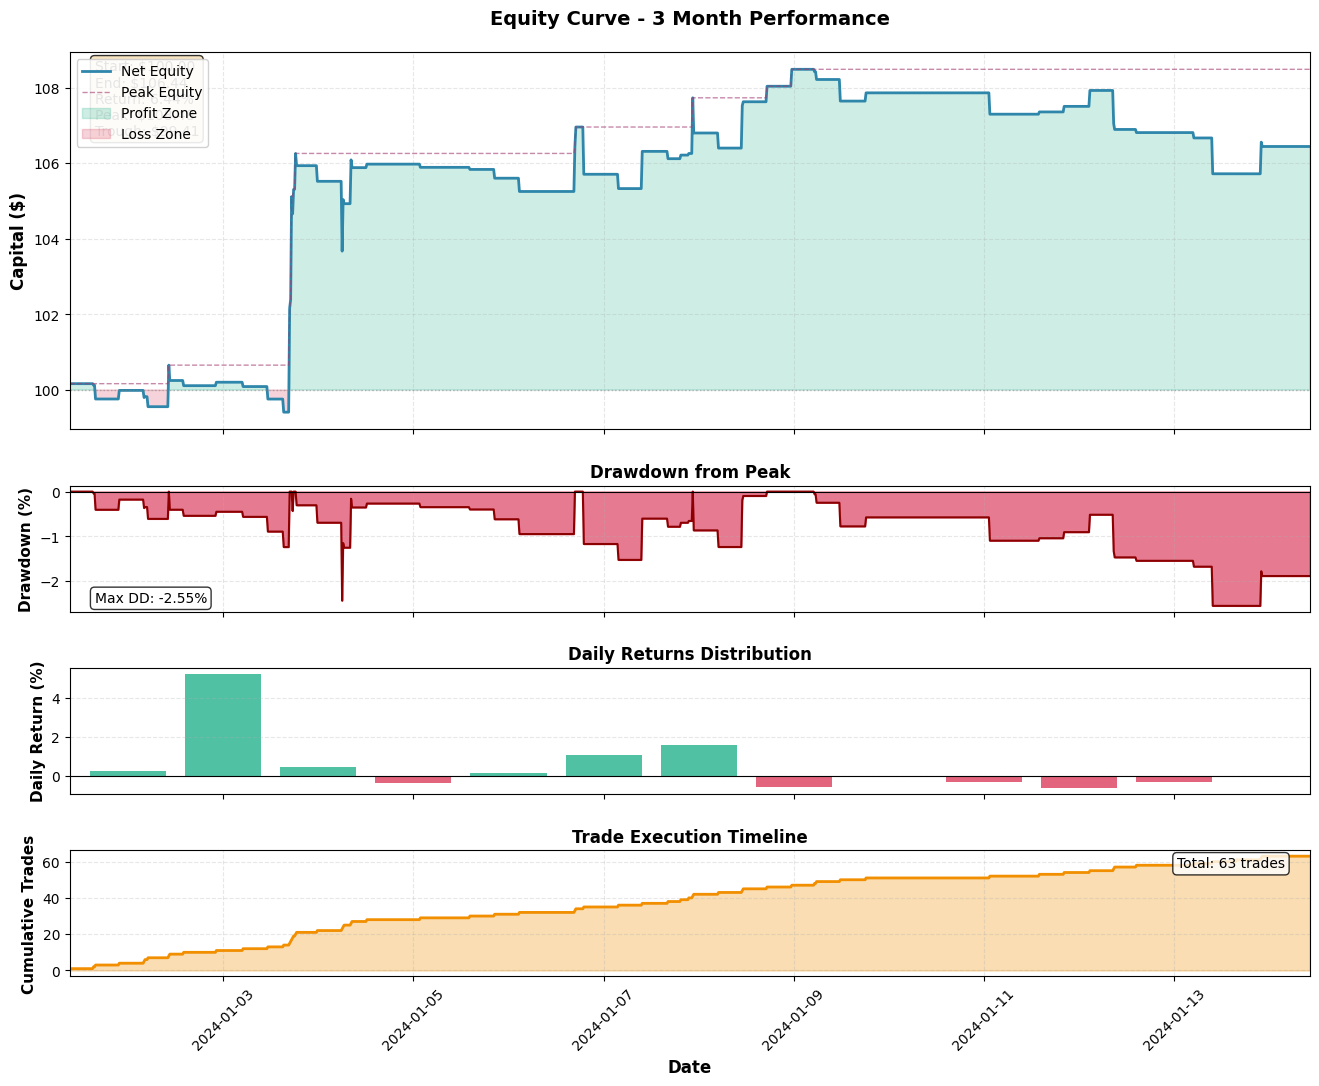

Simple equity curve saved to: /equity_curve_simple.png


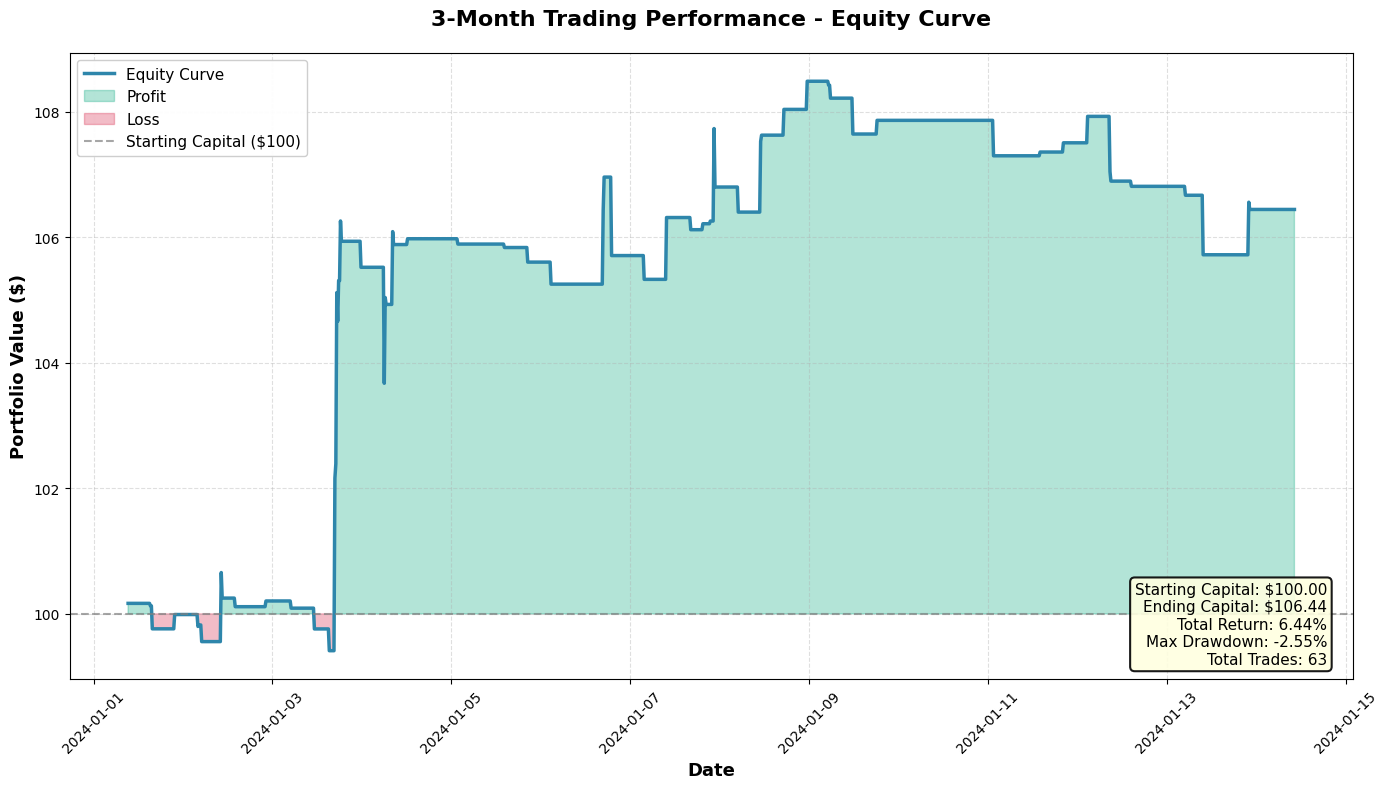


Charts created successfully!
Final Capital: $106.44
Total Return: 6.44%
Max Drawdown: -2.55%


In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Load the data
df = performance_df.copy()

# Parameters
starting_capital = 100
transaction_cost_rate = 0.0004

# Apply trading rules
df['position'] = np.where(((df['y_pred'] == 3) | (df['y_pred'] == 4)) & (df['y_pred_probab'] > 0.31), 1, 0)
df['traded'] = df['position'] != 0

# Calculate returns
df['gross_return'] = df['position'] * df['actual_move']
df['transaction_cost'] = df['traded'] * transaction_cost_rate
df['net_return'] = df['gross_return'] - df['transaction_cost']

# Calculate capital progression
df['capital'] = starting_capital * (1 + df['net_return']).cumprod()
df['capital_prev'] = df['capital'].shift(1).fillna(starting_capital)

# Add datetime if not present
if 'datetime' not in df.columns:
    start_date = pd.Timestamp('2024-01-01 09:15:00')
    df['datetime'] = [start_date + timedelta(minutes=15*i) for i in range(len(df))]

df['datetime'] = pd.to_datetime(df['datetime'])

# Calculate drawdown
df['running_max'] = df['capital'].cummax()
df['drawdown_pct'] = ((df['capital'] - df['running_max']) / df['running_max']) * 100

# Create figure with multiple subplots
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(4, 1, height_ratios=[3, 1, 1, 1], hspace=0.3)

# 1. Main Equity Curve
ax1 = fig.add_subplot(gs[0])
ax1.plot(df['datetime'], df['capital'], linewidth=2, color='#2E86AB', label='Net Equity')
ax1.plot(df['datetime'], df['running_max'], linewidth=1, linestyle='--', 
         color='#A23B72', alpha=0.6, label='Peak Equity')
ax1.fill_between(df['datetime'], starting_capital, df['capital'], 
                  where=(df['capital'] >= starting_capital), 
                  color='#06A77D', alpha=0.2, label='Profit Zone')
ax1.fill_between(df['datetime'], starting_capital, df['capital'], 
                  where=(df['capital'] < starting_capital), 
                  color='#D62246', alpha=0.2, label='Loss Zone')

ax1.axhline(y=starting_capital, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax1.set_ylabel('Capital ($)', fontsize=12, fontweight='bold')
ax1.set_title('Equity Curve - 3 Month Performance', fontsize=14, fontweight='bold', pad=20)
ax1.legend(loc='upper left', framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xlim(df['datetime'].min(), df['datetime'].max())

# Add annotations
final_capital = df['capital'].iloc[-1]
total_return = ((final_capital / starting_capital) - 1) * 100
max_capital = df['capital'].max()
min_capital = df['capital'].min()

textstr = f'Start: ${starting_capital:.2f}\n'
textstr += f'End: ${final_capital:.2f}\n'
textstr += f'Return: {total_return:.2f}%\n'
textstr += f'Peak: ${max_capital:.2f}\n'
textstr += f'Trough: ${min_capital:.2f}'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# 2. Drawdown Chart
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.fill_between(df['datetime'], 0, df['drawdown_pct'], 
                  color='#D62246', alpha=0.6)
ax2.plot(df['datetime'], df['drawdown_pct'], linewidth=1.5, color='#8B0000')
ax2.set_ylabel('Drawdown (%)', fontsize=11, fontweight='bold')
ax2.set_title('Drawdown from Peak', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

max_dd = df['drawdown_pct'].min()
ax2.text(0.02, 0.05, f'Max DD: {max_dd:.2f}%', transform=ax2.transAxes, 
         fontsize=10, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Daily Returns
daily_returns = df.groupby(df['datetime'].dt.date)['net_return'].sum() * 100
daily_dates = pd.to_datetime(daily_returns.index)

ax3 = fig.add_subplot(gs[2], sharex=ax1)
colors = ['#06A77D' if x >= 0 else '#D62246' for x in daily_returns.values]
ax3.bar(daily_dates, daily_returns.values, color=colors, alpha=0.7, width=0.8)
ax3.set_ylabel('Daily Return (%)', fontsize=11, fontweight='bold')
ax3.set_title('Daily Returns Distribution', fontsize=12, fontweight='bold')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax3.grid(True, alpha=0.3, linestyle='--', axis='y')

# 4. Cumulative Trades
df['cumulative_trades'] = df['traded'].cumsum()
ax4 = fig.add_subplot(gs[3], sharex=ax1)
ax4.plot(df['datetime'], df['cumulative_trades'], linewidth=2, 
         color='#F18F01', label='Total Trades')
ax4.fill_between(df['datetime'], 0, df['cumulative_trades'], 
                  color='#F18F01', alpha=0.3)
ax4.set_ylabel('Cumulative Trades', fontsize=11, fontweight='bold')
ax4.set_xlabel('Date', fontsize=12, fontweight='bold')
ax4.set_title('Trade Execution Timeline', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, linestyle='--')

total_trades = df['traded'].sum()
ax4.text(0.98, 0.95, f'Total: {total_trades} trades', transform=ax4.transAxes, 
         fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Format x-axis
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
ax4.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig('equity_curve.png', dpi=300, bbox_inches='tight')
print("Equity curve chart saved to: /home/claude/equity_curve.png")

# Show plot
plt.show()

# Additional: Create a simple single-panel version
fig2, ax = plt.subplots(figsize=(14, 8))
ax.plot(df['datetime'], df['capital'], linewidth=2.5, color='#2E86AB', label='Equity Curve')
ax.fill_between(df['datetime'], starting_capital, df['capital'], 
                where=(df['capital'] >= starting_capital), 
                color='#06A77D', alpha=0.3, label='Profit')
ax.fill_between(df['datetime'], starting_capital, df['capital'], 
                where=(df['capital'] < starting_capital), 
                color='#D62246', alpha=0.3, label='Loss')

ax.axhline(y=starting_capital, color='gray', linestyle='--', linewidth=1.5, 
          alpha=0.7, label=f'Starting Capital (${starting_capital})')

ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Portfolio Value ($)', fontsize=13, fontweight='bold')
ax.set_title('3-Month Trading Performance - Equity Curve', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.4, linestyle='--')

# Add statistics box
stats_text = f'Starting Capital: ${starting_capital:.2f}\n'
stats_text += f'Ending Capital: ${final_capital:.2f}\n'
stats_text += f'Total Return: {total_return:.2f}%\n'
stats_text += f'Max Drawdown: {max_dd:.2f}%\n'
stats_text += f'Total Trades: {total_trades}'

ax.text(0.98, 0.02, stats_text, transform=ax.transAxes, 
       fontsize=11, verticalalignment='bottom', horizontalalignment='right',
       bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9, 
                edgecolor='black', linewidth=1.5))

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('equity_curve_simple.png', dpi=300, bbox_inches='tight')
print("Simple equity curve saved to: /equity_curve_simple.png")
plt.show()

print("\nCharts created successfully!")
print(f"Final Capital: ${final_capital:.2f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Max Drawdown: {max_dd:.2f}%")

In [257]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Load the data
df = performance_df.copy()

# Parameters
starting_capital = 100
transaction_cost_rate = 0.0004

# Apply trading rules
df['position'] = np.where(((df['y_pred'] == 3) | (df['y_pred'] == 4)) & (df['y_pred_probab'] > 0.29), 1, 0)
df['traded'] = df['position'] != 0

# Calculate returns
df['gross_return'] = df['position'] * df['actual_move']
df['transaction_cost'] = df['traded'] * transaction_cost_rate
df['net_return'] = df['gross_return'] - df['transaction_cost']

# Calculate capital progression (compounding)
df['capital'] = starting_capital * (1 + df['net_return']).cumprod()
df['capital_prev'] = df['capital'].shift(1).fillna(starting_capital)

# M2M calculations
df['m2m_gross'] = df['gross_return'] * df['capital_prev']
df['m2m_net'] = df['net_return'] * df['capital_prev']

# Add datetime if not present (assuming sequential 15-min bars)
if 'datetime' not in df.columns:
    # OPTION 1: If you know the actual time period, set it here
    ACTUAL_MONTHS = 3  # Change this to your actual time period in months
    ACTUAL_DAYS = ACTUAL_MONTHS * 30  # Approximate calendar days
    
    # Create synthetic datetime spanning the actual period
    start_date = pd.Timestamp('2024-01-01 09:15:00')
    # Calculate time increment to span ACTUAL_DAYS
    total_bars = len(df)
    minutes_per_bar = (ACTUAL_DAYS * 24 * 60) / total_bars
    df['datetime'] = [start_date + timedelta(minutes=minutes_per_bar*i) for i in range(len(df))]
    
    print(f"WARNING: Using synthetic datetime spanning {ACTUAL_MONTHS} months ({ACTUAL_DAYS} days)")
    print(f"If this is incorrect, please provide actual 'datetime' column in your dataframe")
    print()
else:
    print("Using actual datetime from dataframe")
    print()
    
df['date'] = pd.to_datetime(df['datetime']).dt.date

# Daily aggregation
daily_stats = df.groupby('date').agg({
    'traded': 'sum',
    'm2m_gross': 'sum',
    'm2m_net': 'sum',
    'capital': 'last'
}).reset_index()

daily_stats['daily_return'] = daily_stats['m2m_net'] / daily_stats['capital'].shift(1).fillna(starting_capital)
daily_stats['profit_day'] = daily_stats['m2m_net'] > 0
daily_stats['loss_day'] = daily_stats['m2m_net'] < 0

# Calculate drawdown
daily_stats['running_max'] = daily_stats['capital'].cummax()
daily_stats['drawdown'] = (daily_stats['capital'] - daily_stats['running_max']) / daily_stats['running_max']

# Find max drawdown period
max_dd_idx = daily_stats['drawdown'].idxmin()
max_dd_value = daily_stats.loc[max_dd_idx, 'drawdown']
max_dd_end = daily_stats.loc[max_dd_idx, 'date']

# Find start of max drawdown
dd_start_idx = daily_stats.loc[:max_dd_idx, 'running_max'].idxmax()
max_dd_start = daily_stats.loc[dd_start_idx, 'date']

# Calculate consecutive wins/losses for days
daily_stats['profit_streak'] = (daily_stats['profit_day'] != daily_stats['profit_day'].shift()).cumsum()
daily_stats['loss_streak'] = (daily_stats['loss_day'] != daily_stats['loss_day'].shift()).cumsum()

max_consec_win_days = daily_stats[daily_stats['profit_day']].groupby('profit_streak').size().max() if daily_stats['profit_day'].any() else 0
max_consec_loss_days = daily_stats[daily_stats['loss_day']].groupby('loss_streak').size().max() if daily_stats['loss_day'].any() else 0

# Signal-level statistics (individual trades)
trade_df = df[df['traded']].copy()
trade_df['profit_signal'] = trade_df['net_return'] > 0
trade_df['loss_signal'] = trade_df['net_return'] < 0

# Consecutive wins/losses for signals
trade_df['signal_profit_streak'] = (trade_df['profit_signal'] != trade_df['profit_signal'].shift()).cumsum()
trade_df['signal_loss_streak'] = (trade_df['loss_signal'] != trade_df['loss_signal'].shift()).cumsum()

max_consec_win_signals = trade_df[trade_df['profit_signal']].groupby('signal_profit_streak').size().max() if trade_df['profit_signal'].any() else 0
max_consec_loss_signals = trade_df[trade_df['loss_signal']].groupby('signal_loss_streak').size().max() if trade_df['loss_signal'].any() else 0

# Time period calculations
total_days = len(daily_stats)
total_trading_days = (daily_stats['traded'] > 0).sum()

# Calculate actual time span
start_date = daily_stats['date'].min()
end_date = daily_stats['date'].max()
actual_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 1
years = actual_days / 365.25  # Calendar days to years

# Calculate all metrics
final_capital = df['capital'].iloc[-1]
total_return = (final_capital / starting_capital) - 1

# CAGR - annualized return
cagr = ((final_capital / starting_capital) ** (1 / years) - 1) if years > 0 else 0

# Calmar Ratio
calmar = cagr / abs(max_dd_value) if max_dd_value != 0 else 0

# Sharpe Ratio (annualized)
returns = trade_df['net_return']
mean_return = returns.mean()
std_return = returns.std()
sharpe = (mean_return / std_return) * np.sqrt(252) if std_return > 0 else 0

# Sortino Ratio (annualized)
downside_returns = returns[returns < 0]
downside_std = downside_returns.std()
sortino = (mean_return / downside_std) * np.sqrt(252) if downside_std > 0 and len(downside_returns) > 0 else 0

# Ulcer Index (uses daily data)
ulcer_squared = (daily_stats['drawdown'] ** 2).mean()
ulcer_index = np.sqrt(ulcer_squared) if ulcer_squared >= 0 else 0

# VaR (Value at Risk) - 95% and 99%
var_95 = np.percentile(trade_df['m2m_net'], 5)
var_99 = np.percentile(trade_df['m2m_net'], 1)

# Day-level statistics
profit_days = daily_stats['profit_day'].sum()
loss_days = daily_stats['loss_day'].sum()
profit_day_pct = (profit_days / total_trading_days * 100) if total_trading_days > 0 else 0
losing_day_pct = (loss_days / total_trading_days * 100) if total_trading_days > 0 else 0

avg_winning_day = daily_stats[daily_stats['profit_day']]['m2m_net'].mean() if profit_days > 0 else 0
avg_losing_day = daily_stats[daily_stats['loss_day']]['m2m_net'].mean() if loss_days > 0 else 0

# Signal-level statistics
total_signals = len(trade_df)
profit_signals = trade_df['profit_signal'].sum()
loss_signals = trade_df['loss_signal'].sum()
profit_signal_pct = (profit_signals / total_signals * 100) if total_signals > 0 else 0
losing_signal_pct = (loss_signals / total_signals * 100) if total_signals > 0 else 0

avg_winning_signal = trade_df[trade_df['profit_signal']]['m2m_net'].mean() if profit_signals > 0 else 0
avg_losing_signal = trade_df[trade_df['loss_signal']]['m2m_net'].mean() if loss_signals > 0 else 0

trades_per_day = total_signals / total_trading_days if total_trading_days > 0 else 0

# Compile results
metrics_dict = {
    "initial_capital": starting_capital,
    "final_capital_net": final_capital,
    "total_days_traded": total_trading_days,
    "total_m2m_gross": df['m2m_gross'].sum(),
    "total_m2m_net": df['m2m_net'].sum(),
    "total_return_net": total_return * 100,
    "cagr_net": cagr * 100,
    "max_drawdown_pct": max_dd_value * 100,
    "max_drawdown_start_datetime": max_dd_start,
    "max_drawdown_end_datetime": max_dd_end,
    "calmar_ratio_net": calmar,
    "sharpe_net": sharpe,
    "sortino_net": sortino,
    "ulcer_index_net": ulcer_index * 100,
    "var_95_net": var_95,
    "var_99_net": var_99,
    "profit_day_pct": profit_day_pct,
    "losing_day_pct": losing_day_pct,
    "avg_winning_day": avg_winning_day,
    "avg_losing_day": avg_losing_day,
    "max_consec_win_days": max_consec_win_days,
    "max_consec_loss_days": max_consec_loss_days,
    "trades_per_day": trades_per_day,
    "profit_signal_pct": profit_signal_pct,
    "losing_signal_pct": losing_signal_pct,
    "avg_winning_signal": avg_winning_signal,
    "avg_losing_signal": avg_losing_signal,
    "max_consec_win_signals": max_consec_win_signals,
    "max_consec_loss_signals": max_consec_loss_signals
}

# Print results
print("="*100)
print("COMPREHENSIVE TRADING METRICS")
print("="*100)
print(f"\n{'TIME PERIOD':-^100}")
print(f"Start Date:                         {start_date}")
print(f"End Date:                           {end_date}")
print(f"Total Calendar Days:                {actual_days}")
print(f"Period in Years:                    {years:.4f}")
print(f"\n{'CAPITAL & RETURNS':-^100}")
print(f"Initial Capital:                    ${metrics_dict['initial_capital']:.2f}")
print(f"Final Capital (Net):                ${metrics_dict['final_capital_net']:.2f}")
print(f"Total M2M Gross:                    ${metrics_dict['total_m2m_gross']:.2f}")
print(f"Total M2M Net:                      ${metrics_dict['total_m2m_net']:.2f}")
print(f"Total Return (Net):                 {metrics_dict['total_return_net']:.2f}%")
print(f"CAGR (Net):                         {metrics_dict['cagr_net']:.2f}%")

print(f"\n{'RISK METRICS':-^100}")
print(f"Max Drawdown:                       {metrics_dict['max_drawdown_pct']:.2f}%")
print(f"Max DD Start:                       {metrics_dict['max_drawdown_start_datetime']}")
print(f"Max DD End:                         {metrics_dict['max_drawdown_end_datetime']}")
print(f"Calmar Ratio:                       {metrics_dict['calmar_ratio_net']:.4f}")
print(f"Sharpe Ratio:                       {metrics_dict['sharpe_net']:.4f}")
print(f"Sortino Ratio:                      {metrics_dict['sortino_net']:.4f}")
print(f"Ulcer Index:                        {metrics_dict['ulcer_index_net']:.4f}%")
print(f"VaR 95%:                            ${metrics_dict['var_95_net']:.4f}")
print(f"VaR 99%:                            ${metrics_dict['var_99_net']:.4f}")

print(f"\n{'DAILY STATISTICS':-^100}")
print(f"Total Days Traded:                  {metrics_dict['total_days_traded']}")
print(f"Profit Days:                        {metrics_dict['profit_day_pct']:.2f}%")
print(f"Losing Days:                        {metrics_dict['losing_day_pct']:.2f}%")
print(f"Avg Winning Day:                    ${metrics_dict['avg_winning_day']:.4f}")
print(f"Avg Losing Day:                     ${metrics_dict['avg_losing_day']:.4f}")
print(f"Max Consecutive Win Days:           {metrics_dict['max_consec_win_days']}")
print(f"Max Consecutive Loss Days:          {metrics_dict['max_consec_loss_days']}")
print(f"Trades Per Day:                     {metrics_dict['trades_per_day']:.2f}")

print(f"\n{'SIGNAL STATISTICS':-^100}")
print(f"Profit Signals:                     {metrics_dict['profit_signal_pct']:.2f}%")
print(f"Losing Signals:                     {metrics_dict['losing_signal_pct']:.2f}%")
print(f"Avg Winning Signal:                 ${metrics_dict['avg_winning_signal']:.4f}")
print(f"Avg Losing Signal:                  ${metrics_dict['avg_losing_signal']:.4f}")
print(f"Max Consecutive Win Signals:        {metrics_dict['max_consec_win_signals']}")
print(f"Max Consecutive Loss Signals:       {metrics_dict['max_consec_loss_signals']}")

print("="*100)

# Return as dataframe for easy export
metrics_df = pd.DataFrame([metrics_dict])
print("\nMetrics DataFrame:")
print(metrics_df.T)

If this is incorrect, please provide actual 'datetime' column in your dataframe

COMPREHENSIVE TRADING METRICS

--------------------------------------------TIME PERIOD---------------------------------------------
Start Date:                         2024-01-01
End Date:                           2024-03-31
Total Calendar Days:                91
Period in Years:                    0.2491

-----------------------------------------CAPITAL & RETURNS------------------------------------------
Initial Capital:                    $100.00
Final Capital (Net):                $103.43
Total M2M Gross:                    $7.89
Total M2M Net:                      $3.43
Total Return (Net):                 3.43%
CAGR (Net):                         14.51%

--------------------------------------------RISK METRICS--------------------------------------------
Max Drawdown:                       -7.45%
Max DD Start:                       2024-03-15
Max DD End:                         2024-03-25
Calmar Ratio: